# Homework 3 -- Neural models

In [ ]:
num_threads = 1  # if you change this number you have to restart the notebook

# A hyperparameter for the size of all the hidden layers throughout the notebook.
HIDDEN_SIZE = 30

# set this before we import numpy
import os
os.environ['OMP_NUM_THREADS'] = str(num_threads)


import numpy as np
from scipy.misc import logsumexp
import sys
import re
from itertools import islice
from pprint import pprint
import math
import csv
from collections import namedtuple
import random

import scipy.optimize

import torch
from torch import nn, optim, Tensor, FloatTensor, LongTensor
from torch.autograd import Variable
import torch.nn.functional as F

def var(val):
    return Variable(torch.FloatTensor(val), requires_grad=True)

torch.set_num_threads(num_threads)


from seq2class_homework1 import (
    TaskSetting,
    ProbabilityModel,
    BoltzmannModel,
    DecisionAgent,
    ViterbiAgent,
    BayesAgent,
    L2LogLikelihood,
    SGDTrainer
)


Data_type = namedtuple('Data', ['xx', 'oo', 'yy'])

# data loading for the IOB task
def iterate_data(filename='train', *, max_examples=None):
    file = open(f'iob/{filename}.tsv')
    for n, row in enumerate(csv.DictReader(file, delimiter='\t')):
        if max_examples and n >= max_examples:
            break
        yield Data_type(
            xx=tuple(row['xx'].split()),
            oo=None,  # we are not dealing with partial observations in this homework
            yy=tuple(row['yy'].split()) if 'yy' in row else None,
        )

        
# data loading for the parsing task
Parse_Data_type = namedtuple('ParseData', ['xx', 'aa'])
def iterate_trees(filename='train', *, max_examples=None):
    file = open(f'trees/{filename}.tsv')
    for n, row in enumerate(csv.DictReader(file, delimiter='\t')):
        if max_examples and n >= max_examples:
            break
        yield Parse_Data_type(
            xx=tuple(row['xx'].split(' ')),
            aa=tuple(map(int, row['aa'].split())),
        )
        

Copy over your `IobTask0` from homework 2.  We will be reusing the IobTask as a a warm up to transition based neural parsing.

In [ ]:
from seq2class_homework2 import (
    IobTask0 as IobTask,
    Integerizer,
    F1
)

iob_task = IobTask()

## PyTorch Basics

For this assignment we will be using [PyTorch](http://pytorch.org/) to build a neural transition based parser.  We will build up to writing a full parser by building constructing a neural representation of our words from the character sequence of each word.  We will use our character representation to train a neural Iob tagger and eventually our neural parser.



#### Documentation links:
1. [Torch general documentation](http://pytorch.org/docs/stable/torch.html)
2. [Torch neural network layers](http://pytorch.org/docs/stable/nn.html)

#### Neural network layers that we will use through this assignment
| Neural Layer | Use |
|---|---|
| [nn.Linear](http://pytorch.org/docs/master/nn.html#torch.nn.Linear) | A single feed forward linear layer with bias. |
| [nn.LSTMCell](http://pytorch.org/docs/master/nn.html#torch.nn.LSTMCell) | Implements a single step of an LSTM returning the new hidden and cell states. |
| [nn.Embedding](http://pytorch.org/docs/master/nn.html#torch.nn.Embedding) | Holds an embedding matrix for tokens indexed by an integer array. |
| [nn.Parameter](http://pytorch.org/docs/master/nn.html#torch.nn.Parameter) | Holds a raw tensor but adds it to the list of parameters for training |

#### Useful PyTorch functions :
| Function | Use |
|---|---|
| [torch.cat](http://pytorch.org/docs/stable/torch.html#torch.cat) | concatenate tensors along a given dimension |
| [torch.stack](http://pytorch.org/docs/stable/torch.html#torch.stack) | adds a new dimension when combing tensors |
| [F.tanh](http://pytorch.org/docs/stable/nn.html#torch.nn.functional.tanh) | Hyperbolic tangent function (non-linearity) |
| [F.softmax](http://pytorch.org/docs/stable/nn.html#torch.nn.functional.softmax) | Compute the softmax over a tensor |
| [torch.zeros](http://pytorch.org/docs/stable/torch.html#torch.zeros) | Returns a new tensor filled with zeros |
| [torch.rand](http://pytorch.org/docs/stable/torch.html#torch.rand) | Returns a new tensor filled with random values in the $[0, 1)$ interval |
| [`Variable(..)`](http://pytorch.org/tutorials/beginner/former_torchies/autograd_tutorial.html#variable) | A variable tracks the operations applied to a tensor for use with back propagation |

# Part 1: Backpropagating through Matrices and Checking your Answer

Backward-mode automatic differentiation a.k.a. backpropagation is the algorithmic workhorse of 
deep learning. It fuses the [chain rule](https://en.wikipedia.org/wiki/Chain_rule), taken from calculus, and [memoization](https://en.wikipedia.org/wiki/Memoization), a technique from algorithms. 

Let’s first talk about the calculus. As students, you likely spent a lot of time manually taking derivatives with respect to real scalars in univariate calculus and with respect to real vectors in multi-variate calculus. If you took complex analysis, you may have even taken derivatives with respect to complex-valued quantities. But what of matrices? In deep learning, we are often interested in the derivative with respect to a real matrix. For instance, consider this simple log-linear model for binary classification: $p(y \mid x) = \textit{sigmoid}(W x)$, where $x \in \mathbb{R}^d$ is the input to the model, $W \in \mathbf{R}^{2 \times d}$ is a matrix of parameters. Typically, we choose $W$ so as to minimize the loss ${\cal L}(W) = -\sum_{i=1}^n \log p(y^{(i)} \mid x^{(i)})$, perhaps with a regularization terms, which we would achieve algorithmically by following the gradient $\frac{\partial L}{\partial W}$. 

To get you comfortable with taking derivatives with respect to matrices, we often a series of pen-and-pencil exercises to get you warmed up. Note that the general strategy will be to break down the function into a series of sums, using the definition of the matrix operations, and then apply standard techniques from univariate calculus. 


### Question 1: The Derivative of Latent Semantic Analysis (LSA)

Suppose you have a large matrix $X \in \mathbb{R}^{N \times M}$ and you would like to approximately factorize it.  We saw this *matrix factorization* problem in class: *latent semantic analysis (LSA)* is the case where $X_{ij}$ is the number of times word $i$ appears in context $j$.  In this question, however, we will generalize by allowing the entries of $X$ to be real numbers rather than counts.

Let us try to express $X \approx AB$ where $A \in \mathbb{R}^{N \times K}$ and $B \in \mathbb{R}^{K \times M}$.  Note that $\textit{rank}(AB) \leq K$.  By setting $K$ to a small value, we can ensure that this rank is less than the original $\textit{rank}(X)$, which may be as large as $\min(N,M)$.  Thus, we regard $AB$ as a low-rank approximation to $X$.

Specifically, let's try to minimize ${\cal L}_\textit{lsa}(A, B) = \frac{1}{2}||X - AB||^2_F$, where $||\cdot||_F$ denotes the [Frobenius norm](http://mathworld.wolfram.com/FrobeniusNorm.html) of a matrix.

While we can globally minimize this particular objective by running Singular Value Decomposition, one may also use gradient descent, albeit without the globally optimal guarantee. So, let's figure out the gradient of the objective with respect to the parameters—namely the elements of $A$ and $B$.


#### The Gradient of Matrix Multiplication

The goal is to compute $\frac{\partial {\cal L}_\textit{lsa}}{\partial A}$ and $\frac{\partial {\cal L}_\textit{lsa}}{\partial B}$.  But what does that even mean when $A$ and $B$ are matrices?  We'd better try temporarily eliminating the matrix notation and just using good old single-variable calculus:
$$ {\cal L}_\textit{lsa}(A, B) = \frac{1}{2}||X - AB||^2_F = \frac{1}{2}\sum_{i'=1}^N \sum_{j'=1}^M (X_{i'j'} - \sum_{k'=1}^K A_{i'k'} B_{k'j'})^2$$

Now for any fixed $i,j,k$, you should be able to write down formulas for both $\frac{\partial {\cal L}_\textit{lsa}}{\partial A_{ik}}$ and $\frac{\partial {\cal L}_\textit{lsa}}{\partial A_{kj}}$.  (We used $i',j',k'$ in the objective function above so that you could keep the summation indices separate from the indices of the specific fixed variable that you are differentiating with respect to.)

Congratulations: you have just written formulas for computing $NK + KM$ different partial derivatives.  It's convenient to store all those real numbers in a pair of matrices, which are what we call $\frac{\partial {\cal L}_\textit{lsa}}{\partial A} \in \mathbb{R}^{N \times K}$ and $\frac{\partial {\cal L}_\textit{lsa}}{\partial B} \in \mathbb{R}^{K \times M}$.  

Can you write formulas that compute those matrices using only matrix operations (which are fast in numpy and PyTorch)?  Check: the correct answer requires multiplication and subtraction on matrices.

$$
\begin{align*}
\frac{\partial {\cal L}_\textit{lsa}}{\partial A} &= \color{red}{\text{FILL IN}} \\
\frac{\partial {\cal L}_\textit{lsa}}{\partial B} &= \color{red}{\text{FILL IN}} \\
\end{align*}
$$


In [ ]:
# variables
n = 5; k = 2
# random initialization of the parameters
A = Variable(torch.randn(n, k), requires_grad=True)
B = Variable(torch.randn(n, k), requires_grad=True)
# random positive matrix to factorize
X = Variable(torch.exp(torch.randn(n, n)))

In [ ]:
def Llsa(A, B):
    """
    Loss function for matrix factorization
    """
    C = torch.mm(A, B.transpose(1, 0))
    loss = 0.5 * ((X-C)**2).sum()
    return loss

### Automatic Differentiation
Recall that pyTorch will automatically compute gradients for you using [reverse-mode automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation#Reverse_accumulation). This algorithm was discussed and demoed in class. See it in action below.

In [ ]:
A.grad = None
B.grad = None
loss = Llsa(A, B)
loss.backward()
dLlsa_dA_auto = A.grad.data.numpy()
dLlsa_dB_auto = B.grad.data.numpy()

### Now, fill in the following functions with your answer from above


In [ ]:
def dLlsa_dA(A, B):
    """ Computes the derivative of L with respect to the matrix A"""
    ### STUDENTS START
    raise NotImplementedError()  # REPLACE ME
    ### STUDENTS END


In [ ]:
def dLlsa_dB(A, B):
    """ Computes thederivative of L with respect to the matrix B """
    ### STUDENTS START
    raise NotImplementedError()  # REPLACE ME
    ### STUDENTS END


In [ ]:
# the following two assert statements should pass if you did it right :-)
assert np.allclose(dLlsa_dA_auto, (dLlsa_dA(A, B)), atol=1e-2)
assert np.allclose(dLlsa_dB_auto, (dLlsa_dB(A, B)), atol=1e-2)

## Question 3: The Derivative of Skip-Gram

Again, let $X \in \mathbb{R}^{n \times n}$ and let $A, B \in \mathbb{R}^{n \times m}$. We will
consider the function ${\cal L}_{\textit{skipgram}}(A, B) = \sum_{i=1}^n \sum_{j=1}^n X_{ij} \log p(i \mid j ; A, B)$, 
whose derivative you will find with respect to both $A$ and $B$. We define 

$p(i \mid j; A, B) = \textit{softmax}((AB^{\top})_{:j})_i = \frac{\exp\,(AB^{\top})_{ij}}{\sum_{i'=1}^n \exp\, (AB^{\top})_{i'j}}$

Recall from class that this objective is called the [skip-gram](https://en.wikipedia.org/wiki/Word2vec) objective, which is part of the word2vec toolkit. 

In [ ]:
def Lskipgram(A, B):
    logit = torch.mm(A, B.transpose(1, 0))
    return (X * F.log_softmax(logit, dim=0)).sum()

In [ ]:
# HINT: these two matrices (and their names) should help you see relation
# between the gradient of skip-gram's matrices and those of the log-linear model
# you saw in NLP assignment 3. 
logit = torch.mm(A, B.transpose(1, 0))
P = F.softmax(logit, dim=0)
X_expected = torch.mm(P, torch.diag(X.sum(0).squeeze(0)))


### Now, fill in the following functions


In [ ]:
def dLskipgram_dA(A, B):
    """ Computes the derivative of L with respect to the matrix A"""
    ### STUDENTS START
    raise NotImplementedError()  # REPLACE ME
    ### STUDENTS END


In [ ]:
def dLskipgram_dB(A, B):
    """ Computes thederivative of L with respect to the matrix B """
    ### STUDENTS START
    raise NotImplementedError()  # REPLACE ME
    ### STUDENTS END


In [ ]:
# automatic differentiation again
A.grad = None
B.grad = None
loss = Lskipgram(A, B)
loss.backward()
dLskipgram_dA_auto = A.grad.data.numpy()
dLskipgram_dB_auto = B.grad.data.numpy()

In [ ]:
# the following two assert statements should pass if you did it right :-)
assert np.allclose(dLskipgram_dA_auto, (dLskipgram_dA(A, B)), atol=1e-2)
assert np.allclose(dLskipgram_dB_auto, (dLskipgram_dB(A, B)), atol=1e-2)

### Question 3

Let’s suppose, for a second, we didn’t have an automatic differentiation toolkit available? Is there, perhaps, another way that we can use a computer to compute the gradient? The most common numerical method as our disposal is called the finite-difference check. In this exercise, I will derive the method for you and have you all implement.

#### Background
Consider a smooth function $f : \mathbb{R}\rightarrow \mathbb{R}$. Recall from calculus,
that for $x, \varepsilon \in \mathbb{R}$, the first-order Taylor approximation of $f$ may be written
as

$
f(x + \varepsilon) = f(x) + \varepsilon f'(x) + o(|\varepsilon|^2)
$

Note that if little-o notation is unfamiliar to you, just interpret $o(|\varepsilon|^2)$
as the order of magnitude of the error term. More often, this formula is written as,

$
    f'(x) \approx  \frac{f(x + \varepsilon) - f(x)}{\varepsilon}
$

The equation above is termed the **forward difference** in the numerical analysis literature.  
Note that in the limit as $\varepsilon \rightarrow 0$, the equation is exact. Indeed,
you may recognize this as the definition of the derivative. We may also consider the
**backward difference**

$
    f'(x) \approx  \frac{f(x) - f(x - \varepsilon)}{\varepsilon}
$

which follows were we to replace $(x+\varepsilon)$ with $(x-\varepsilon)$ in the derivation
of the forward difference from the Taylor approximation. Averaging the forward and backward difference,
yields the **central difference**.

$
f'(x) \approx \frac{f(x + \varepsilon) - f(x - \varepsilon)}{2\varepsilon}
$



### Question 3: Operationalizing the finite-difference check

Now, I am going to ask you to operationalize the finite-difference check. Given a function $f(x) = \sin(x^2) + 10$, we are going to ask you to implement the finite-difference method and compare the output to a derivative you compute symbolically. Note that *checking* the correctness of derivative and gradient computations is a primary use case of the finite-difference method.


In [ ]:
def f(x):
    """ a fun function"""
    return np.sin(x**2) + 10

In [ ]:
def df(x):
    """ compute the derivative of f symbolically"""
    ### STUDENTS START
    raise NotImplementedError()  # REPLACE ME
    ### STUDENTS END


In [ ]:
def df_fd(x, eps=1e-5):
    """ compute the derivative of f using the finite-difference check"""
    ### STUDENTS START
    raise NotImplementedError()  # REPLACE ME
    ### STUDENTS END


In [ ]:
# if you have done it right, these two checks should pass
assert np.allclose(df(5.0), df_fd(5.0), atol=1e-2)
assert np.allclose(df(-2.0), df_fd(-2.0), atol=1e-2)

### Question 4: Extension to functions of many variables

In the land of machine learning, we are generally interested in computing the derivative of a function
of many variables: $f : \mathbb{R}^n \rightarrow \mathbb{R}$. How do we extend the finite-difference check to this case? As it turns out, it's quite trivial. Say we have $f(x_1, \ldots, x_n)$, to compute $\nabla_{\mathbf{x}} f$, we simply perform the univariate finite-difference check on each component of the input. This next question, we ask that you write a function to do this for a parameter $Y \in \mathbb{R}^{n \times m}$. 


In [ ]:
def finite_difference(Y, f, eps=1e-2):
    """ compute the finite-difference approximation for the function f"""
    # populate this numpy matrix
    dY = np.zeros((n, k))
    ### STUDENTS START
    raise NotImplementedError()  # REPLACE ME
    ### STUDENTS END
    return dY

In [ ]:
# the following two assert statements should pass if you did it right :-)
assert np.allclose(dLskipgram_dA_auto, finite_difference(A, lambda Y: Lskipgram(Y, B)), atol=1e-2)
assert np.allclose(dLskipgram_dB_auto, finite_difference(B, lambda Y: Lskipgram(A, Y)), atol=1e-2)

### Question 5: Runtime Analysis of the the finite-difference check

Let $f : \mathbb{R}^{n \times k} \rightarrow \mathbb{R}$ be a smooth function, e.g., the objective of LSA or skip-gram. Give a big-O analysis of the runtime for the finite-difference method in terms of $n$ and $k$, assuming you can compute the value of the function in $O(1)$. Now, give a big-O analysis of the runtime of automatic differentiation in terms of $n$ and $k$? What does this analysis ever tell you about the practicality of the finite-difference method for computing the derivatives within an optimization routine for neural networks?

$\color{red}{\text{FILL IN}}$

# Part 2: Embedding words using their character representation

As a warm-up, we will embed actual words using recurrent neural networks, specifically using long short-term memory (LSTM). We would like for each word to be represented as a single fixed sized vector, this will allow us to more easily feed into later stages of our training pipe line.  We are going to accomplish this using a character level LSTM over the characters in the word.

For each word in the sequence `xx`, we are going to split it into characters and represent each character an integer.  To pass this representation into the LSTM, we will use a one-hot encoding, meaning at each step we will apply the LSTM to a tensor that contains a single 1 value and zeros otherwise.

Throughout this homework, we will be using [LSTMCell](http://pytorch.org/docs/master/nn.html#torch.nn.LSTMCell), which only applies the a single step of the LSTM.  This means that you will have to handle passing the hidden states between different time steps of the LSTM

### Question 6
Your next task is to analyze the code toy model below. Pay close attention to the `def foward` method, which loops over the characters
in the input word, encodes each as a [one-hot vector](https://en.wikipedia.org/wiki/One-hot), and, then,
calls ``self.character_lstm``. In short, you are unfolding the LSTM over the character stream. The sanity checks below should help guide you. You will implement similar methods in the next questions. 

In [ ]:
class CharacterLSTMPreprocessModule(nn.Module):
    """
    CharacterLSTMPreprocessModule takes an `xx` input string, and maps it to an embedding tensor using a
    character level LSTM over each input word.  We 
    """
    
    def __init__(self, integerizer):
        super().__init__()
        
        # string integerizer from homework 2
        self.integerizer = integerizer
        
        # the parameters and submodules for this module
        self.character_lstm = nn.LSTMCell(len(integerizer), HIDDEN_SIZE)
        self.character_lstm_init = nn.Parameter(torch.rand(1, HIDDEN_SIZE))
        
    def forward(self, *, xx):
        """
        Preprocess the input sequence xx into something that we can then process
        at the token level.
        """
        output = []
        for x in xx:
            # initalize the hidden state of the LSTM
            cx = self.character_lstm_init
            hx = torch.tanh(cx)
            for c in x:
                i = torch.zeros(len(self.integerizer))
                i[self.integerizer.index(c)] = 1
                hx, cx = self.character_lstm(Variable(i), (hx, cx))
            output.append(hx)
        return torch.stack(output, 1)

#### Basics sanity checks

In [ ]:
# basic tests for the character LSTM module

dutch_character_integerizer = Integerizer(tuple(set(w for d in iterate_data('train') for w in ' '.join(d.xx))))

dutch_preprocess = CharacterLSTMPreprocessModule(dutch_character_integerizer)

print('Parameters in model:\n\t'+ '\n\t'.join(list(name for name,value in dutch_preprocess.named_parameters())))

# get a first example out of the dutch training data
xx, oo, yy = next(iterate_data('train-small'))
xx_processed = dutch_preprocess(xx=xx)

# check that the output is a PyTorch variable and that the size has
# a 1 in the first dimention to represent the mini-batch
# the length of the input sentence for the second dimention
# the HIDDEN_SIZE to represent the size of the hidden state that we are using to represent words
assert isinstance(xx_processed, Variable)
assert xx_processed.shape == (1,len(xx),HIDDEN_SIZE)

#### Basic training task for `CharacterLSTMPreprocessModule`

The above only checked that the output of `CharacterLSTMPreprocessModule` was the correct shape, however to check that the model is actually capable of learning a function, we need to set up a simple task.

Below, we have defined `SimpleWordClassification` which takes the embedding of a word and attempts to predict if the word contains the letter 'e'.
This model classifies a word by performing $p_i = \sigma(W e(\text{word}_i) + b)$, where it applies a linear transform of $Wx + b$ to the output of our embedding layer $e(\cdot)$ and then a sigmoid function to map to $[0, 1]$.

To train this model, we need to define a *training loss*.  For this simple model we define the training loss as the squared difference between the correct label and the predicted label $\sum_i (l_i - p_i)^2$.  To train the model, we need to take the derivative of *all* the parameters with respect to the scalar that represents the training loss.  This is done for us *automatically* when calling PyTorch's `.backward()` method on the loss variable.

For this simple model, we are choosing to train it using just standard [SGD](http://pytorch.org/docs/master/optim.html#torch.optim.SGD) like in the previous homeworks. However, this function is again provided for by PyTorch.  Using `torch.optim.SGD`, we take a list of all the parameters in the model (which we can get as `model.parameters()`) and a learning rate.  Once we have computed the gradients (as described above), `optimizer.step()` to take a single step in the direction of the gradient.  Note, that the optimizers in PyTorch are always seeking to *minimize* the loss (so if you want to maximize a value do `(-reward).backward()`).

If you have correctly implemented `CharacterLSTMPreprocessModule` you should see that large difference between the positive and negative training examples below.

In [ ]:
class SimpleWordClassification(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.word_embedding = dutch_preprocess
        self.word_classifier = nn.Linear(HIDDEN_SIZE, 1)
        
    def forward(self, xx):
        embedding = self.word_embedding(xx=xx)  # this will call self.word_embedding.forward(....)
        return F.sigmoid(self.word_classifier(embedding))
    
dutch_words = set(x for d in iterate_data('train') for x in d.xx)
# split the words such that there is some classification boundary that we can learn
# here we are using words that contain the letter 'e'
positive_words = set(word for word in dutch_words if 'e' in word)
negative_words = dutch_words - positive_words

simple_classifier = SimpleWordClassification()

optimizer = torch.optim.SGD(simple_classifier.parameters(), lr=.05)
for _ in range(2):
    for word in dutch_words:
        score = simple_classifier([word])
        loss = (int(word in positive_words) - score)**2

        # compute the gradient of all parameters with respect to the loss variable
        loss.backward()

        # make the optimization method take a single step
        optimizer.step()

        # the gradient is accumulated into special a .grad value each parameter.
        # we need to zero .grad otherwise PyTorch will just accumulate the next 
        # gradient on top of the old one
        #
        # Keeping .step() seperate from .zero_grad() is useful in the case that 
        # there are multiple operations which will use the same gradients
        optimizer.zero_grad()
    
    
    # quickly test how well the model is doing on the *training* data
    positive_average = simple_classifier(list(positive_words)).mean()
    negative_average = simple_classifier(list(negative_words)).mean()
    
    print(f'Positive example average: {float(positive_average)}, '
          f'Negative example average: {float(negative_average)}')
    


## Part 3: Transition-based Tagging
Throughout the remainder of this homework, we will be defining transition models which define *how* we transition from an "opaque" state $\mathbf s$ to another "opaque" state $\mathbf s'$ given an action $y_i$.  During each transition, we will compute a score $g = G(\mathbf s')$ which we will learn such that we generate the correct $\mathbf y$ output string.

$$ f: (\mathbf s, y_i) \mapsto (\mathbf s', g) $$

Below, you can see the base class for our transition models.

In [ ]:
class TransitionModel(nn.Module):
    """
    A base class for all of our transistion models that we are going to implement in this homework.
    """
    
    def __init__(self, task):
        super().__init__()
        self.task = task

    def iterate_y(self, *, state, xx, yy_prefix):
        """
        Iterate over transition actions y that we can take given the current state, yy_prefix and xx
        """
        yield from self.task.iterate_y(xx=xx, yy_prefix=yy_prefix)
        
    def initial_state(self, *, xx, xx_embedding):
        """
        Return the initial state representation given the input xx.
    
        This could include running a backwards LSTM over the input sequence
        as well as creating an empty forward LSTM state.
        """    
        raise NotImplementedError()
        
    def forward(self, *, state, xx, xx_embedding, yy_prefix, y):
        """
        Perform the forward $f$ function transition.  This should map s -> s' and 
        Score the state s' using the learned G function.
        """
        raise NotImplementedError()

## IOB Transition Model

For our IOB transition-based tagger, we will have a backwards LSTM which is encoding the words we have *yet* to see in the sentence as well as a forward LSTM which encodes which word we just read and the IOB tag that we chose to assign to that word.

<img width=450px src='images/iob-lstm.png'>

In the above figure, we just processed the third word $x_3$ and assigned it tag $y_3$.  Each circle represents a step of the LSTM where we are passing the hidden state to the next time step.  As we consume more tokens of the $\mathbf x$ input, we will *pop* off states of the backwards LSTM which represents the lookahead, and we will *push* the new representation computed by the forward LSTM.

You should probably look at the [decision agent](#DecisionAgent) below to see exactly how we are going to use the transition model before you attempt to implement it.

In [ ]:
class IobTransitionModel(TransitionModel):
    """
    This module represents the operations that are looking forward at each step
    
    Note, that there is a lot of copying of arrays which should maybe help with keeping the different components
    isolated, but I would probably not do that in practice as I think that this is a bit awkard?
    """

    def __init__(self, iob_task):
        super().__init__(iob_task)
        
        # the lstms that encode the input sequence.
        # the input for the forward state should be our representation for each word and
        # a one hot encoding for which IOB tag we are generating
        self.forward_lstm = nn.LSTMCell(HIDDEN_SIZE + 3, HIDDEN_SIZE)
        self.backward_lstm = nn.LSTMCell(HIDDEN_SIZE, HIDDEN_SIZE)
        
        # score the current state given the hidden forward and backward LSTMs state.
        self.score_function = nn.Linear(HIDDEN_SIZE*2, 1)
        
        # The initial hidden states, represents the EOS and BOS for the respective LSTMs
        self.lstm_init_backwards = nn.Parameter(torch.rand(1, HIDDEN_SIZE))
        self.lstm_init_forwards = nn.Parameter(torch.rand(1, HIDDEN_SIZE))
        
    def iterate_y(self, *, state, xx, yy_prefix):
        """
        Iterate through valid IOB assignments given the prefix.
        If we are at the end of the string, then do not yield any additional y actions 
        to indicate that we are done.
        """
        if len(yy_prefix) < len(xx):
            yield from self.task.iterate_y(xx=xx, yy_prefix=yy_prefix)
        
    def initial_state(self, *, xx, xx_embedding):
        """
        Return the initial state vector for this model
        xx is a vector represention of this input that comes from the preprocessing step
        The preprocessing step might select the word vectors or use a character LSTM to embed the words
        """
        lookahead = []
        cx = self.lstm_init_backwards
        hx = torch.tanh(cx)  # I suppose that this is suppose to be times the o output symbol? which we don't have
        lookahead = [hx]
        
        for i in range(xx_embedding.shape[1]-1, -1,-1):  # run this backwards through the states
            x = xx_embedding[:,i]
            hx, cx = self.backward_lstm(x, (hx, cx))
            lookahead.append(hx)
        cx = self.lstm_init_forwards
        hx = torch.tanh(cx)
        # return the lookahead for the x_{0:n} and an empty initial forward state (hx, cx)
        return tuple(lookahead), (hx, cx)
    
    def forward(self, *, state, xx, xx_embedding, yy_prefix, y):
        """
        Take the previous state which is an opaque blob that represents the neuralized path representing
        this state
        as well as the x label that we are currently reading and 
        """
        lookahead, (hx, cx) = state
        
        x = xx_embedding[:, len(yy_prefix)]  # get the representation for this timestep
        yi = Variable(torch.zeros(1, 3))
        yi[0, 'IOB'.index(y)] = 1
        
        # this is a generative model, so we are jointly scoring P(x,y) which means we concatenate
        # the embedding representation to a one hot embedding of IOB
        inp = torch.cat((x, yi), 1)
        
        # compute the hidden states of the LSTM (hx, cx) and the score function
        ### STUDENTS START
        raise NotImplementedError()  # REPLACE ME
        ### STUDENTS END
            
        # return the tuple for the next state which is the lookahead with the list slicing off one state
        # and the most recent hidden states from the forward passes with the LSTM
        lookahead = lookahead[:-1]
       
        return score, (lookahead, (hx, cx))

IobTransitionModel(IobTask())

### Training a Transition Model

To train our transition model, we would ideally like to maximize the log probability of $P(\mathbf y \mid \mathbf x)$, however, we are unable to efficiently compute the normalizing function $Z(\mathbf x)$ as we do not have a dynamic program over the $\mathbf y$ strings and thus would require computing the exponentially sized $\mathcal{Y}$ set.

Instead, we are going to train our transition model to assign a high score to the correct path when using a decision agent.

Below, you will find `BrokenGreedyDecisionAgent`.  This agent correctly implements the *interface* for working with a `TransitionModel`, however when trying to use it for training you will observe some strange behavior that we will correct later in this assignment.

<a name="DecisionAgent"></a>

In [ ]:
class PyTorchDecisionAgent(nn.Module, DecisionAgent):
    """
    Base class for our Decision Agent class using the PyTorch
    """
    
    def __init__(self, task, preprocessor, model):
        # init the base pytorch module
        nn.Module.__init__(self) 
        
        self.task = task
        self.preprocessor = preprocessor
        self.model = model
        
    def decision(self, *, xx, oo=None):
        """
        Call the self.forward() method which implements the decision rule
        """
        assert oo is None, "Our Neural models do not support oo values"
        loss, yy = self(xx=xx)  # through pytorch this calls self.forward()
        return yy

    def forward(self, *, xx, yy=None):
        """
        Implement the decision agent's decoding rule.
        
        Arguments:
            `xx`: The input string
            `yy`: The our desired output.  If unset, run the decoding rule and select the "best" yy
        
        Returns a tuple of (loss of the selected yy, and the selected yy)
        """
        raise NotImplementedError()

In [ ]:
class BrokenGreedyDecisionAgent(PyTorchDecisionAgent):
    """
    This Decision Agent performs a greedy decoding of output sequence.
    It is complete and ment to serve as an example for how you can structure other decision agents in this
    homework, however it is *broken* as we will see later in this assignment.
    """
    
    def forward(self, *, xx, yy=None):
        """
        xx represents input sequence
        yy represents the gold sequence if known
        """
        
        # run the preprocessor to generate a representation for each token in the input xx
        xx_embedding = self.preprocessor(xx=xx)
        
        # create the initial state for our decoding model
        state = self.model.initial_state(xx=xx, xx_embedding=xx_embedding)
        
        yy_prefix = []
        loss = 0  # this is the loss that we are collecting at each step
        while True:
            actions = []
            action_scores = []
            action_states = []
            
            for y in self.model.iterate_y(xx=xx, yy_prefix=yy_prefix, state=state):
                # call the forward method on the model
                # The model should return a score and a new state
                nscore, nstate = self.model(xx=xx, 
                                            xx_embedding=xx_embedding,
                                            state=state, 
                                            yy_prefix=yy_prefix, 
                                            y=y)
                actions.append(y)
                action_scores.append(nscore)
                action_states.append(nstate)
                
            if len(actions) == 0:
                # there were no new actions to perform, so we must have reached the end
                break
            
            if yy is not None:
                # then there is a gold yy sequence, so we are going to choose the action that matches the gold path
                action = actions.index(yy[len(yy_prefix)])
            else:
                # there is no gold action, so choose the one that is the "best"
                action = max(range(len(actions)), key=lambda i: float(action_scores[i]))
            
            # we are trying to minimize the loss, so we add the negative action score
            # as we want to maximize the action score of along this path
            loss += -action_scores[action]
            # the state now holds whatever state was generated by our underlying model of the selected action
            state = action_states[action]
            # add the selected action the the prefix of the yy string that we are generating
            yy_prefix.append(actions[action])
        # we are done decoding this sequence
        # return the loss that we calculated along the way as well as the yy prefix as it contains all of yy
        return loss, tuple(yy_prefix)

The `BrokenGreedyDecisionAgent` correctly implements the *interface* for working with our models, so you can use this to tests that you have correctly implemented `CharacterLSTMPreprocessModule` and `IobModule`, however when training you should observe some strange behavior.

What do you observe about the loss.  How does this model perform on the testing data?  Why do you think that is?

**Answer:** <span style='color:red'>FILL IN</span>

Fill in `LocallyNormalizedGreedyDecisionAgent` to change the way that we are computing loss to the product of the locally normalized actions at each step.  **Mention that this should be using the softmax over the scores of the states**


Some discussion about the `PyTorchTrainer` and using [Adam](http://pytorch.org/docs/master/optim.html#torch.optim.Adam) as our accelerated decent method.

In [ ]:
from random import shuffle
import time
class PyTorchTrainer(object):
    
    def __init__(self, trainable_agent, epochs=1, evaluate=None, optimizer=None):
        self._model = trainable_agent
        if optimizer is None:
            # create an optimizer with the default settings
            # model.parameters() is a list of all the trainable parameters in the model
            optimizer = torch.optim.Adam(self._model.parameters())
        self._optimizer = optimizer
        self._epochs = epochs
        self._evaluate = evaluate
        
    def train(self, dataset):
        iteration = 0
        dataset = list(dataset)
        running_loss = 0
        start = time.time()
        for _ in range(self._epochs):
            shuffle(dataset)
            for example in dataset:
                # compute the loss from the model (trainable decision agent)
                loss, *_ = self._model(xx=example.xx, yy=example.yy)
                # compute the gradients on the computation graph
                loss.backward()  
                # make the optimizer take a step using the computed gradients
                self._optimizer.step()
                # zero out the gradients for the next step
                self._optimizer.zero_grad()
                running_loss = running_loss * .99 + float(loss)
                iteration += 1
                if iteration % 50 == 0:
                    # print progress
                    done = iteration / (len(dataset) * self._epochs)
                    now = time.time()
                    total_time = (now - start) / done
                    sys.stdout.write(f'\r\ttrained for {iteration} iterations, loss {running_loss/100} '
                                     f'{int(done*100)}% time: {int((now - start) / 60)}/{int(total_time / 60)} (min)  ') 
            if self._evaluate:
                sys.stdout.write('\n')
                self._evaluate(self._model)

Try out your `IobTransitionModel` to ensure that everything is working before moving on to the next part of the assignment.

In [ ]:
iob_model = IobTransitionModel(iob_task)
iob_preprocess = CharacterLSTMPreprocessModule(dutch_character_integerizer)
greedy_iob = BrokenGreedyDecisionAgent(iob_task, iob_preprocess, iob_model)

trainer = PyTorchTrainer(
    greedy_iob, 
    epochs=1,
    evaluate=lambda x: x.test_F1(iterate_data('dev'))
)

%time trainer.train(iterate_data('train'))

1. What loss did your `IobTransitionModel` get after training with the `BrokenGreedyDecisionAgent`:  
**Answer:** <span style='color:red'>FILL IN</span>

2. What is the *lower bound* on the training loss when using `BrokenGreedyDecisionAgent`:  
**Answer:** <span style='color:red'>FILL IN</span>

3. How well dose your model perform on the development data after using `BrokenGreedyDecisionAgent`, what possible explanations are there for this performance?  
**Answer:** <span style='color:red'>FILL IN</span>



### Locally Normalized Greedy Decision Agent


In the above decision agent we defined the training loss to be the sum of score assigned to each action ($-\sum_i G_{y_i}(\mathbf s_i)$).  Now we are going to try changing this to a locally normalized model or a [MEMM](https://en.wikipedia.org/wiki/Maximum-entropy_Markov_model).

<img width=450px src='images/memm.png'>

In a memm, we are going to define the training loss to be the negative log probability of all the decision that we have to make along the way.

$$ \text{training loss} = -\log \prod_i p(\mathbf s_i) = - \sum_i \log p(\mathbf s_i) $$

Just like in our previous Boltzmann models, the probability will be defined as $p(\mathbf s_i) = \frac{\exp G(s_i)}{\sum_{y_i \in \mathcal{Y}} G(f(s_{i-1}, y))}$.



In [ ]:
class LocallyNormalizedGreedyDecisionAgent(PyTorchDecisionAgent):
    
    def forward(self, *, xx, yy=None):
        """
        xx represents input sequence
        yy represents the gold sequence if known
        """    
        ### STUDENTS START
        raise NotImplementedError()  # REPLACE ME
        ### STUDENTS END
        return loss, tuple(yy_prefix)

In [ ]:
iob_model = IobTransitionModel(iob_task)
iob_preprocess = CharacterLSTMPreprocessModule(dutch_character_integerizer)
greedy_iob = LocallyNormalizedGreedyDecisionAgent(iob_task, iob_preprocess, iob_model)

trainer = PyTorchTrainer(
    greedy_iob, 
    epochs=3,
    evaluate=lambda x: x.test_F1(iterate_data('dev')))

%time trainer.train(iterate_data('train'))

1. What is the lower bound of the loss for `LocallyNormalizedGreedyDecisionAgent`  
**Answer**: <span style='color:red'>FILL IN</span>
2. How well does `LocallyNormalizedGreedyDecisionAgent` perform on the Iob task, why do you think that this agent is better or worse than the previous broken agent.  
**Answer**: <span style='color:red'>FILL IN</span>

## Beam decoding

In the greedy decoding agent above, we are only looking at the one best action.  Additionally, we are only looking at the actions that we can take given that we *made* to to the correct action so far, and as such we are only able to perform local normalization.

Instead, we would like to work with a *globally* normalized model (like we have seen in the previous two assignments).  This requires that we are able to compute a $Z(\mathbf x)$.  However, given that we are unable to efficiently compute the exact value of $Z(\mathbf x)$, we are going to instead approximate $Z$.

To estimate $Z$ during training and introduce a more powerful decision agent we are going to use [Beam search](https://en.wikibooks.org/wiki/Artificial_Intelligence/Search/Heuristic_search/Beam_search).  Instead of just maintaining the one best, we are going to have a list of the top $k$ possibilities.  We then approximate $Z(x) = \sum_{j=0}^k \exp(G(\mathbf s_n^{(i)}))$, as the sum of sequences that made it to the end of the beam.

Here is the basic algorithmic description of beam search:

```text
    beam = [ (0, initial_state) ]
    while not done:
        next_beam = []
        for item on beam:
            for next possible y actions for item:
                g, next_state = f(item, y) 
                score = ???
                next_beam.add((score, next_state))
        beam = choose top k items from next_beam
    loss = -log P(gold sequence) = -log exp(gold) / Z(x)
```

Hints: 
1. This is a globally normalized model, the score of a sequence is the *sum* of $g$ from all steps instead of the score of just the most recent operation.
2. When you are training your model, it is possible that the *gold* sequence falls off of the beam and will not make it to the end.

In [ ]:
class BeamDecisionAgent(PyTorchDecisionAgent):
        
    def __init__(self, *args, beam_size=10, **kwargs):
        super().__init__(*args, **kwargs)
        self.beam_size = beam_size
    
    def forward(self, *, xx, yy=None):
        """
        Perform beam search
        return the loss for the best path and the best path
            xx is the input sequence
            yy (if set) represents the gold sequence.  Return the loss for the yy sequence
        """
        ### STUDENTS START
        raise NotImplementedError()  # REPLACE ME
        ### STUDENTS END
        
        if yy:
            # if there is a gold yy sequence, then we should return that path
            # loss should correspond to the path that we are returning
            assert tuple(best_yy_path) == tuple(yy)
        
        return loss, best_yy_path

In [ ]:
iob_model = IobTransitionModel(iob_task)
preprocess = CharacterLSTMPreprocessModule(dutch_character_integerizer)
beam_iob = BeamDecisionAgent(iob_task, preprocess, iob_model)

trainer = PyTorchTrainer(beam_iob, 
                         epochs=3, 
                         evaluate=lambda x: x.test_F1(iterate_data('dev')))

%time trainer.train(iterate_data('train'))

# Part 4: Recurrent Neural Shift-Reduce Parsing

For our next act, we will introduce a recurrent neural shift-reduce
parser. In contrast to CKY and Earley's algorithm, which have a worst-case
runtime of $O(n^3)$ for sentences of length $n$, shift-reduce parsers
run in $O(n)$ time. This gives them a practical relevance in
real-world applications benefit from syntactic information. Also, in
contrast to 601.465, we will focus on dependency grammar, rather than
constituency grammar.

An excellent introduction to dependency parsing may be found in
the [tome](https://www.amazon.com/Dependency-Synthesis-Lectures-Language-Technologies/dp/1598295969/ref=sr_1_1?ie=UTF8&qid=1524716345&sr=8-1&keywords=dependency+parsing), which may be downloaded for free on
the Johns Hopkins network. For completeness, we will briefly overview
the formalism. Consider the sentence:

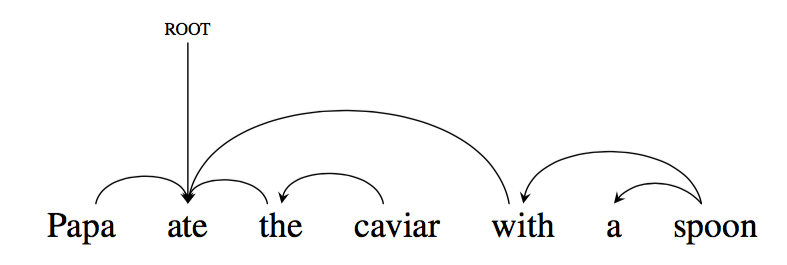

Formally, let $\mathbf{x}
\in \Sigma^*$, where $\Sigma$ is an alphabet, a finite non-empty set,
where we have augmented $\Sigma$ with a distinguished root symbol
*ROOT*. Given a sentence of length $|\mathbf{x}| = n$, a dependency parse of
$\mathbf{x}$, which we will denote ${\cal T}(\mathbf{x})$, is is a directed tree on
$(n+1)$ nodes, rooted at ROOT. There is a bijection between the
non-ROOT nodes of ${\cal T}(\mathbf{x})$ and the words of $\mathbf{x}$. In this
assignment, we will focus on *projective* dependency
parsing. Visually, a dependency parse is considered projective if,
drawing all the arcs above the sentence, it is the case that none of
them cross. The sentence above has a projective parse.
We refer the reader to [McDonald et al. (2005)](http://www.aclweb.org/anthology/H05-1066) for an example of an English sentence with a non-projective parse.
For a formal definition of projectivity, see [Nivre (20080)](https://www.mitpressjournals.org/doi/pdf/10.1162/coli.07-056-R1-07-027). 


### Question 9
Before moving onto shift-reduce parsing, we will allow for a brief interlude to consider dependency parsing
using an algorithm you already know.  There is a tight relationship between projective dependency parses and constituency parses. In this question, we ask that you design a dynamic-programming
algorithm to parse dependency grammar. We expect you to do this the following way. Given an input sentence $\xx$ of length $n$,
design a sentence-specific context-free grammar ${\cal G}(\mathbf{x})$ that, when provided to CKY, will yield dependency parses of $\mathbf{x}$. What is the runtime (in terms of
$n$) of this algorithm?

**Answer:** $\color{red}{\text{FILL IN}}$


### Question 10
If you're on the right track, you will have found an answer that is $\omega(n^3)$. Can we do better? Eisner's algorithm provides an elegant $O(n^3)$ solution.
A sketch of the algorithm may be found here in [Eisner 1996](http://cs.jhu.edu/~jason/papers/eisner.acl96.pdf). We ask that you read the paper linked,
decipher the prose specification of the algorithm and map it into pseudocode in a style similar to that used for CKY in the slides of 601.465. Please,
as time is limited, only attempt this if you have finished the remainder of the assignment. Give the runtime of Eisner's algorithm

**Answer:** $\color{red}{\text{FILL IN}}$


Now, back to shift-reduce parsers. Shift-reduce parsers for
constituency trace their heritage back to fundamental work on
compilers in the 1960s; see Aho and Ullman (1972) for a
history. However, the modern shift-reduce parser for dependency
grammar is due to Nivre (2003). Shift-reduce parsers rely on a transition
system, which we will take to be a quadruple $S = (C, T, c_s, C_t)$,
following [Nivre 2013](http://stp.lingfil.uu.se/~nivre/master/transition.pdf).

* $C$ is a set of \textbf{configurations},
* $T$ is a set of transitions, each of which is a (partial) function $t: C \rightarrow C$,
* $c_s$ is an initialization function, mapping a sentence $\mathbf{x}$ to its initial configuration $c_s(\mathbf{x})$, 
* $C_t \subseteq C$ is a set of terminal configurations.

A configuration $c$ for a sentence $\mathbf{x}$ is a triple $c = \left(\sigma,
\beta, N \right)$, where $\sigma$ is termed the stack, $\beta$ the
buffer, and $N$ is a set of dependency arcs built so far. Note
that dependency arcs are represented as an ordered pair $(i, j)$ that
denotes a directed arc from the $i^\text{th}$ word in $\mathbf{x}$ towards
the $j^\text{th}$ word in $\mathbf{x}$. 

A myriad transition systems abound, with a veritable cottage industry
dedicated to the development of novel ones. In this work, we will
focus on the so-called *arc-standard* system, which consists
of the following definitions:


* **Initialization:** $c_s(\mathbf{x}) = ([0], [1, \ldots, n]), \emptyset)$
* **Terminal:** $C_t = \{c \in C :  c = ([0], [0], N)  \}$
* **Transitions:** \\
  * *Shift*: $(\sigma, [i \mid \beta], N) \Rightarrow ([\sigma \mid i], \beta, N)$ 
  * *ReduceLeft:* $([\sigma \mid i \mid j], \beta, N) \Rightarrow ([\sigma \mid j], \beta, N \cup \{(j, i)\})$ 
  * *ReduceRight: *$([\sigma \mid i \mid j], \beta, N) \Rightarrow ([\sigma \mid i], \beta, N \cup \{(i, j) \})$
  
We have represented the transitions using the standard notation found
in the dependency-parsing literature. To make it explicit, we will
clarify a few points. We write $c \Rightarrow c'$ to indicate that
configuration $c \in C$ transitions to the configuration $c' \in C$.
We write $[\sigma | i]$ to indicate a stack whose top element is $i$
and whose remaining elements are found in $\sigma$. Similarly, we write
$[i \mid \beta]$ to indicate a buffer whose first element is $i$ and the
remaining elements are $\beta$.

**Important:* To gain a solid intuition for how the arc-standard transition system works, we ask that you view the animation present in the following [slides](http://demo.clab.cs.cmu.edu/fa2015-11711/images/b/b1/TbparsingSmallCorrection.pdf), due to [Miguel Ballesteros](http://miguelballesteros.com/).

**Caveat:** Most dependency parsers also assign an arc label to the arc. We have omitted this for simplicity. 


In [ ]:
class ParsingTask(TaskSetting):
    """
    xx = the sentence
    aa = the parse tree (represented as the id of the parent where 0 is root)
    yy = the shift/reduce actions that build the parse tree 
    """
    
    def __init__(self, false_pos_penalty=1):
        super().__init__()
        self.false_pos_penalty = false_pos_penalty    # lambda
    
    @classmethod
    def convert_to_yy(cls, *, aa):
        """
        Convert the aa sequence (the depedency tree of the parents) to the stack shift/reduce operations
        
        Returns a tuple representing the operations that convert this into a shift/reduce tree.
             0 == shift operation
             1 == reduce right
             2 == reduce left
        """
        stack = [(0, None)]
        i = 0
        # the stack actions that we have to perform
        operations = []
        while True:
            if len(stack) >= 2 and stack[-2][0] == stack[-1][1] and stack[-1][0] not in aa[i:]:
                # the top element of the stack is the child of the second on the top of the stack
                operations.append(2)  # left
                del stack[-1]
            elif len(stack) >= 2 and stack[-2][1] == stack[-1][0]:
                # the second element on the stack is the child of the item just added to the stack
                operations.append(1)  # right
                del stack[-2]
            else:
                # then we are going to perform a shift action
                if i >= len(aa):
                    break
                operations.append(0)  # shift
                id, parent = i + 1, aa[i]
                i += 1
                stack.append((id, parent))
        assert len(stack) == 1 and stack[0][0] == 0
        
        # return a list of shift and
        return tuple(operations)
    
    @classmethod
    def convert_to_aa(cls, *, yy):
        """
        Convert stack operations back to the depedency tree
        """
        l = yy.count(0)  # count the number of words
        assert l * 2 == len(yy)  # There should be exactly twice as many operations as words
        aa = [-1] * l  # the list of parents

        stack = [-1]
        i = 0
        for y in yy:
            if y == 0:
                # perform a shift operation by adding to the stack word i
                stack.append(i)
                i += 1
            elif y == 1:
                # perform shift right by marking the parent of the second element on the stack
                # and removing it from the stack
                aa[stack[-2]] = stack[-1] + 1
                del stack[-2]
            else:
                # perform shift left
                aa[stack[-1]] = stack[-2] + 1
                del stack[-1]

        assert len(stack) == 1, "stack should only have the root element when it is done, otherwise this is invalid"
        
        return tuple(aa)
    
    @classmethod
    def iterate_data(cls, *args, **kwargs):
        """
        Iterate through our parse data, converting the trees into a series of shift/reduce actions
        That we can train and test on
        """
        for example in iterate_trees(*args, **kwargs):
            yield Data_type(
                xx=example.xx,
                oo=None,  # We are not dealing with partial observations in this homework
                yy=cls.convert_to_yy(aa=example.aa)
            )
    
    def reward(self, *, aa, xx, yy):
        """
        The proxy reward of prediction aa on this sentence if the true chunking is yy.
        """
        aa_gen = self.convert_to_aa(yy=aa)
        aa_gold = self.convert_to_aa(yy=yy)
        
        true_pos = sum(a == b for a,b in zip(aa_gen, aa_gold))
        
        exact = int(aa_gen == aa_gold)
        return true_pos

    def reward_F1_triple(self, *, aa, xx, yy):
        """
        returns a triple (true_pos, true, pos) used to compute corpus-level F1: 
           `true_pos` is the number of "true positives" (chunks reported by `aa` that are truly in `yy`) 
           `true` is the number of chunks that are truly in `yy`  
           `pos` is the number of chunks reported by `aa`
        """
        # aa is the predicted output
        # yy is the gold label from the dataset
        # both have already been converted to the shift/reduce operations
        # so we have to convert it back into a tree which lists the parents
        aa_gen = self.convert_to_aa(yy=aa)
        aa_gold = self.convert_to_aa(yy=yy)
        
        true_pos = sum(a == b for a,b in zip(aa_gen, aa_gold))
        return np.array([len(aa_gold), len(aa_gen), true_pos])

parsing_task = ParsingTask()

Please study the following output carefully, to gain an intuition for why the above code converts
dependency parses into sequences of shift and reduce actions. 

In [ ]:
print(ParsingTask.convert_to_yy(aa=(0, 1, 1, 1, 7, 7, 1)))
print(ParsingTask.convert_to_aa(yy=(0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 1, 1, 2, 2)))

for aa in set(p.aa for p in iterate_trees('train')):
    yy = ParsingTask.convert_to_yy(aa=aa)
    aa2 = ParsingTask.convert_to_aa(yy=yy)
    assert aa == aa2
    assert len(yy) == len(aa)*2  # there will always be twice as many shift/reduce operations

The final bit of coding will involve the implementing the forward method of the `ParsingTransitionModel` below. [Dyet et al. (2015)](https://arxiv.org/abs/1505.08075) may be of some help to you. 

In [ ]:
class ParsingTransitionModel(nn.Module):
    
    def __init__(self, task):
        super().__init__()
        
        self.task = task
        self.backward_lstm = nn.LSTMCell(HIDDEN_SIZE, HIDDEN_SIZE)
        self.forward_lstm = nn.LSTMCell(HIDDEN_SIZE, HIDDEN_SIZE)
        
        self.action_network_1 = nn.Linear(HIDDEN_SIZE*2+3, HIDDEN_SIZE)
        self.action_network_2 = nn.Linear(HIDDEN_SIZE, 1)
        
        # network for combining two elements on the stack to make a new representation for this tree
        self.combine_network_1 = nn.Linear(HIDDEN_SIZE*2, HIDDEN_SIZE*2)
        self.combine_network_2 = nn.Linear(HIDDEN_SIZE*2, HIDDEN_SIZE)
        
        self.lstm_init_backwards = nn.Parameter(torch.rand(1, HIDDEN_SIZE))
        self.lstm_init_forwards = nn.Parameter(torch.rand(1, HIDDEN_SIZE))
        
        self.stack_root = nn.Parameter(torch.rand(1, HIDDEN_SIZE))
    
    def initial_state(self, *, xx, xx_embedding):
        """
        xx is going to be the result of the first encoding pass
        and then we want to run the backwards LSTM over this xx sequence
        """
        # this will represent the backwards LSTM over the words that are in the sentence
        lookahead = []
        
        cx = self.lstm_init_backwards
        hx = torch.tanh(cx)
        lookahead.append(hx)
        for i in range(xx_embedding.shape[1]-1,-1,-1):
            hx, cx = self.backward_lstm(xx_embedding[:,i], (hx, cx))
            lookahead.append(hx)
        cx = self.lstm_init_forwards
        hx = torch.tanh(cx)
        # the pre root element on the stack
        stack = [
            (cx, hx, None),  # the -1 element doesn't need an embedding as this will 
        ]
        
        # push the root stack element
        cx, hx = self.forward_lstm(self.stack_root, (hx, cx))
        stack.append((cx, hx, self.stack_root))
        
        processed_tokens = 0
        
        # return a tuple
        return lookahead, stack, processed_tokens
        
    def iterate_y(self, *, state, xx, yy_prefix):
        lookahead, stack, processed_tokens = state
        
        if processed_tokens < len(xx):
            # there are still tokens that this can process
            # yield a shift operation
            yield 0  # shift operation
        if len(stack) > 2:
            # these are the shift operations that we are allowed to perform
            # if one of these are valid then both of these will valid
            yield 1  # right
            yield 2  # left
    
    def forward(self, *, state, xx, xx_embedding, yy_prefix, y):
        ### STUDENTS START
        raise NotImplementedError()  # REPLACE ME
        ### STUDENTS END
        return score, (lookahead, stack, processed_tokens)
        
        
        

In [ ]:
english_character_integerizer = Integerizer(tuple(set(w for d in iterate_trees('train') for w in ' '.join(d.xx))))
parsing_model = ParsingTransitionModel(parsing_task)
preprocess = CharacterLSTMPreprocessModule(english_character_integerizer)

greedy_parse = LocallyNormalizedGreedyDecisionAgent(parsing_task, preprocess, parsing_model)

greedy_trainer = PyTorchTrainer(
    greedy_parse, 
    epochs=3, 
    evaluate=lambda x: x.test_F1(parsing_task.iterate_data('dev')))

%time greedy_trainer.train(parsing_task.iterate_data('train'))

In [ ]:
beam_parser = BeamDecisionAgent(parsing_task, preprocess, parsing_model, beam_size=15)

beam_trainer = PyTorchTrainer(
    beam_parser,
    epochs=3, 
    evaluate=lambda x: x.test_F1(parsing_task.iterate_data('dev')))
    
%time beam_trainer.train(islice(parsing_task.iterate_data('train'), 2000))

## Speedups not covered in this assignment

1. In making a neural model that you actually want to work with, you would probably want to spend some time thinking about how to perform mini-batching.  One of the main reasons that this will speed up our program, is that we are currently performing matrix-vector operations in most cases, in that there is only a single sentence that we are processing at a time.  When mini-batching, you are able to process more than once sentence at a time, this allows for using matrix-matrix operations which will be must faster.  Additionally, less time will be spent on the overhead of PyTorch/Python per sentence we are processing.  Making good use of a GPU will generally require that there are larger matrix-matrix operations which are being performed.

2. Given that this network is *dynamically structured* based off the input of the yy sequence, it can sometimes be difficult to identify a good way to mini-batch multiple sentences at the same time.  An alternate approach is to distribute computation between a number of works that are each processing a single sentence at a time.  This allows us to take advantage of the fact that the sentences themselves are independent from each other while still being able to utilize resources.  [Pytorch multiprocessing documentation](http://pytorch.org/docs/master/notes/multiprocessing.html)

3. You could also try changing the `num_threads` at the top of this notebook to experiment with the number of threads that are used for [BLAS](http://www.netlib.org/blas/) operations.  BLAS is the library that backs all of the matrix operations that you perform in virtually every other library or language (including R, numpy or matlab).  Assuming that you have *sufficiently large* matrices and have enough CPUs cores on your computer, increasing the number of threads that you are using can improve the runtime.


If you want to try to improve the performance of the parser that we built in this notebook, you can try increasing the `HIDDEN_SIZE` that is used throughout.  We set it to 30 by default, but if you set it to larger value like 300, you should expect to see a significant improvement.  Note that the runtime performance scales $O(\texttt{HIDDEN_SIZE}^2)$ so changing the value to 300 will make it take 100 times longer to train assuming that you don't apply any other techniques to speedup your model.

# The final test !!!

Now that you have completed the assignment with the development datasets, try your models on the test dataset for 1 final time.

In [ ]:
### STUDENTS START
### iob_agent = ???
raise NotImplementedError()  # REPLACE ME
### STUDENTS END

iob_agent.test_F1(iterate_data('test'))

In [ ]:
### STUDENTS START
### parse_agent = ???
raise NotImplementedError()  # REPLACE ME
### STUDENTS END

parse_agent.test_F1(parsing_task.iterate_data('test'))